In [1]:
# you can add some bet sizing in. Note here that each time you only risk 250
from wallstreet import Put, Call
import numpy as np
import pandas as pd
import scipy
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
from multiprocessing.dummy import Pool as ThreadPool
%matplotlib inline


from pandas_datareader import data
import datetime as dt
from pandas.tseries.offsets import BDay

pd.set_option('display.max_rows', 500)

In [2]:
global retData

def getReturnData(symbol, retLen = 1, mult = 1, end_date = None):
    start_date  = dt.datetime.now()
    
    if end_date is None:
        end_date = start_date - BDay(10000)
    else:
        end_date = pd.to_datetime(end_date)

    tickerData = data.DataReader(symbol, 'yahoo', end_date, start_date)[:]
    tickerData['Date'] = tickerData.index
    print("Data")
    print("\tMin Date: " + str(tickerData['Date'].min()))
    print("\tMax Date: " + str(tickerData['Date'].max()))
    tickerData.index = [k for k in range(0, len(tickerData))]
    tickerData['logAvgPrice'] = np.log((tickerData['Open'] + tickerData['Close'])/2)
    return np.array(tickerData['logAvgPrice'].shift(-retLen).values[:-retLen] - tickerData['logAvgPrice'].values[:-retLen])*mult

def singlePath(numSteps):

    index = [0]
    retAr = [0]
    for j in range(1, numSteps):
        index.append(j)
        retAr.append(retAr[j - 1] + np.random.choice(retData))
    return retAr[-1]

def getProbData(currentPrice, retData, numSteps, stepSize, numSim):

    numStepAr = [numSteps for x in range(numSim)]
    
    pool = ThreadPool(8) 
    resultAr = pool.map(singlePath, numStepAr)
    pool.close()
                   
    resultAr = np.array(resultAr)
    
    #-1 = [0,-.01,-.02,...-1]
    #1 = [0,.01,.02,...1]
    
    #count the tails
    xVals = np.linspace(-1, 1, 2*stepSize)
    countOccur = [len(resultAr[((resultAr > xVals[i]) & (resultAr < xVals[i+1]))]) for i in range(0, len(xVals)-1)]
    
    xVals = [1 + x for x in xVals]
    yVals = [((countOccur[i])/float(len(resultAr))) for i in range(len(countOccur))]
    
    probData = pd.DataFrame(list(zip(xVals, yVals, countOccur)), columns = ['growthFactor', 'probOccur', 'countOccur'])
    probData['price'] = currentPrice*probData['growthFactor']
    
    return probData, xVals, yVals

def getPutInfo(currentPrice, strikeAr, premiumAr, probData, period, leverage = .5):
    
    expValAr = []
    expValBelow = []
    strikeProbAr = []
    avgLossAr = []
    lossVarAr = []
    for i, strike in enumerate(strikeAr):
        strikeProbAr.append(sum(probData[probData['price'] <= strike]['probOccur']))
        if len(probData[probData['price'] <= strike]) > 0:
            weightedMean = sum((probData[probData['price'] <= strike]['price'] - strike)*probData[probData['price'] <= strike]['probOccur'])*100
            weightedStd = (sum((((probData[probData['price'] <= strike]['price'] - strike) - weightedMean)**2)*probData[probData['price'] <= strike]['probOccur']*100)/sum(probData[probData['price'] <= strike]['probOccur']))**.5
        else:
            weightedMean = 0
            weightedStd = 0
        expValBelow.append(weightedMean)
        avgLossAr.append(weightedMean)
        lossVarAr.append(3*weightedStd)
        expValAr.append((1 - strikeProbAr[i])*premiumAr[i] + expValBelow[i])

    expectedPremium = sum(expValAr)
    cashCommitted = sum(strikeAr*100)
    maxDrawdown = sum(np.array(avgLossAr) - np.array(lossVarAr))
    levCashCommitted = cashCommitted*leverage
    maintMargin = cashCommitted*.5
    threeSigmaDown = cashCommitted + maxDrawdown
    levExpRet = expectedPremium/(cashCommitted*leverage)
    levExpRetAnnual = (expectedPremium/(cashCommitted*leverage))*((52*5)/period)
    
    return cashCommitted,levCashCommitted, maintMargin, threeSigmaDown, expectedPremium, levExpRetAnnual, avgLossAr, lossVarAr, strikeProbAr

def getCallInfo(currentPrice, strikeAr, premiumAr, probData, period, leverage = .5):
    
    expValAr = []
    strikeProbAr = []
    for i, strike in enumerate(strikeAr):
        breakeven = (premiumAr[i]/100) + strike
        weightedMean = sum((probData['price'])*probData['probOccur'])
        expVal = (weightedMean - breakeven)*100
        
        if expVal < premiumAr[i]*-1:
            expVal = premiumAr[i]*-1
            
        expValAr.append(expVal)
        strikeProbAr.append(sum(probData[probData['price'] >= breakeven]['probOccur']))
    return expValAr, strikeProbAr

In [3]:
def loopStrikes(probData, optObj, numDays, currentPrice, dataOut, leverage, direction):
    for strike in optObj.strikes:
        if (((strike < currentPrice) and (direction == -1)) or
            ((strike > currentPrice*.5) and (direction == 1))
            ):
            optObj.set_strike(strike)
            premium = optObj.price*100
            if direction == -1:
                cashCommitted, levCashCommitted, maintMargin, threeSigmaDown, expectedPremium, levExpRetAnnual, avgLossAr, lossVarAr, strikeProbAr = getPutInfo(currentPrice, 
                        [strike], 
                        [premium], 
                        probData, 
                        period = numDays,
                        leverage = 1.0/leverage) 
                dataOut.loc[len(dataOut)] = [strike, optObj.expiration, 
                                         premium, 
                                         strikeProbAr[0], expectedPremium, levExpRetAnnual, avgLossAr[0], avgLossAr[0] - lossVarAr[0], maintMargin > threeSigmaDown,
                                         cashCommitted,levCashCommitted, maintMargin, threeSigmaDown]
            else:
                expValAr, strikeProbAr = getCallInfo(currentPrice, [strike], [premium], probData, period = numDays, leverage = 1.0/leverage)
                dataOut.loc[len(dataOut)] = [strike, optObj.expiration, strikeProbAr[0],
                                         premium, expValAr[0]]
    return dataOut

# Sell Puts

In [20]:
symbol = 'tqqq'
putObj = Put(symbol)
putExpAr = putObj.expirations
currentPrice = putObj.underlying.price
putExpAr

No options listed for given date, using 16-04-2021 instead


['16-04-2021',
 '23-04-2021',
 '30-04-2021',
 '07-05-2021',
 '14-05-2021',
 '21-05-2021',
 '28-05-2021',
 '18-06-2021',
 '17-09-2021',
 '21-01-2022',
 '17-06-2022',
 '20-01-2023']

In [21]:
#Loop options chain and display info
retData = getReturnData(symbol, retLen = 1, mult = 1, end_date = '2010-02-11 00:00:00')
#retData = getReturnData(symbol, retLen = 1, mult = 1, end_date = '2019-02-11 00:00:00')
dataOut = pd.DataFrame(columns = ['strike', 'expiration', 'premium', 
                                  'probAssign', 'expPrem', 'annualExpRet', 'avgLoss', 'threeStdLoss', 'threeStdMarginCall',
                                  'cashCommitted', 'levCashCommitted', 'maintMarginReq', 'positionValueThreeStdLoss'])
#for exp in putExpAr[0:1]:

leverage = 2
exp = putExpAr[3]
expDate = exp.split('-')
strExpDate = expDate[2] + '-' + expDate[1] + '-' + expDate[0]
putObj = Put(symbol, y = int(expDate[2]), m = int(expDate[1]), d = int(expDate[0]))

numDays = np.busday_count(str(dt.datetime.now())[:10], strExpDate) + 1
probData, xVals, yVals = getProbData(currentPrice, retData, int(numDays), 1000, 1000000)

probData = probData[probData['countOccur'] > 0]
probData = probData.sort_values('growthFactor', ascending = False)
dataOut = loopStrikes(probData, putObj, numDays, currentPrice, dataOut, leverage, -1)



Data
	Min Date: 2010-02-11 00:00:00
	Max Date: 2021-04-09 00:00:00


In [22]:
dataOut

,strike,expiration,premium,probAssign,expPrem,annualExpRet,avgLoss,threeStdLoss,threeStdMarginCall,cashCommitted,levCashCommitted,maintMarginReq,positionValueThreeStdLoss
0,45,07-05-2021,50.0,0.000264,49.792724,0.273992,-0.194076,-292.015512,False,4500,2250.0,2250.0,4207.984488
1,50,07-05-2021,15.0,0.000565,14.599209,0.072301,-0.392316,-284.884676,False,5000,2500.0,2500.0,4715.115324
2,55,07-05-2021,42.0,0.001097,41.157059,0.185296,-0.796867,-285.898858,False,5500,2750.0,2750.0,5214.101142
3,60,07-05-2021,26.0,0.002151,24.375295,0.100596,-1.568779,-276.892931,False,6000,3000.0,3000.0,5723.107069
4,65,07-05-2021,32.0,0.004096,28.783518,0.109651,-3.085410,-259.108295,False,6500,3250.0,3250.0,6240.891705
5,70,07-05-2021,54.0,0.007558,47.674421,0.168644,-5.917447,-237.415269,False,7000,3500.0,3500.0,6762.584731
6,75,07-05-2021,68.0,0.013654,56.013464,0.184933,-11.058064,-259.046936,False,7500,3750.0,3750.0,7240.953064
7,80,07-05-2021,98.0,0.024571,75.239267,0.232883,-20.352775,-453.751361,False,8000,4000.0,4000.0,7546.248639
8,81,07-05-2021,187.0,0.027504,158.903186,0.485771,-22.953566,-522.324033,False,8100,4050.0,4050.0,7577.675967
9,81.5,07-05-2021,113.0,0.029280,85.318773,0.259222,-24.372587,-562.363660,False,8150,4075.0,4075.0,7587.636340


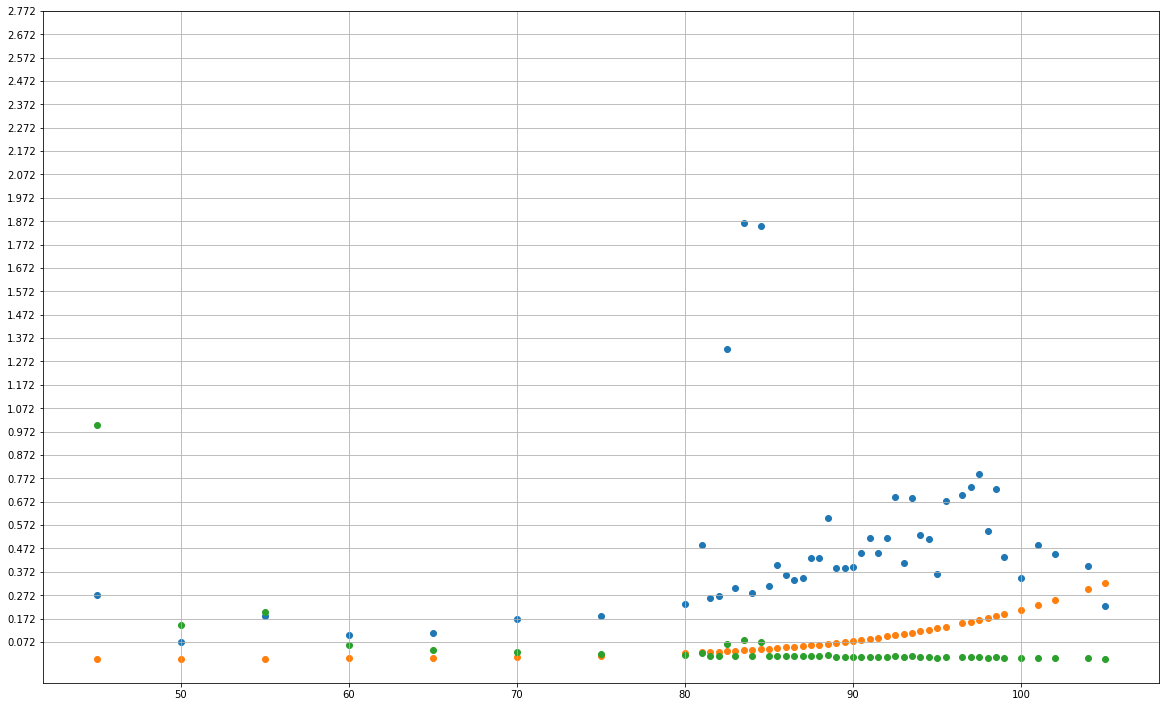

In [23]:
plt.figure(figsize=(20,20/1.618))
plt.scatter(dataOut.strike, dataOut.annualExpRet)
plt.scatter(dataOut.strike, dataOut.probAssign)
lossScaled = abs(dataOut[dataOut.avgLoss != 0].expPrem/dataOut[dataOut.avgLoss != 0].avgLoss)
lossScaled /= lossScaled.max()
plt.scatter(dataOut[dataOut.avgLoss != 0].strike, lossScaled)
plt.yticks(np.arange(min(dataOut.annualExpRet), max(dataOut.annualExpRet)+1, .1))
plt.grid()
plt.show()

# Buy Calls

In [101]:
symbol = 'tqqq'
callObj = Call(symbol)
callExpAr = callObj.expirations
currentPrice = callObj.underlying.price
callExpAr

No options listed for given date, using 12-03-2021 instead


['12-03-2021',
 '19-03-2021',
 '26-03-2021',
 '01-04-2021',
 '09-04-2021',
 '16-04-2021',
 '23-04-2021',
 '18-06-2021',
 '17-09-2021',
 '21-01-2022',
 '17-06-2022',
 '20-01-2023']

In [102]:
retData = getReturnData(symbol, retLen = 1, mult = 1, end_date = '2010-02-11 00:00:00')
dataOut = pd.DataFrame(columns = ['strike', 'expiration', 'probWin', 'premium', 
                                  'expvalue'])


leverage = 2
exp = callExpAr[2]
expDate = exp.split('-')
strExpDate = expDate[2] + '-' + expDate[1] + '-' + expDate[0]
callObj = Call(symbol, y = int(expDate[2]), m = int(expDate[1]), d = int(expDate[0]))

numDays = np.busday_count(str(dt.datetime.now())[:10], strExpDate) + 1
probData, xVals, yVals = getProbData(currentPrice, retData, int(numDays), 1000, 1000000)

probData = probData[probData['countOccur'] > 0]

dataOut = loopStrikes(probData, callObj, numDays, currentPrice, dataOut, leverage, 1)

Data
	Min Date: 2010-02-11 00:00:00
	Max Date: 2021-03-08 00:00:00


In [103]:
dataOut

,strike,expiration,probWin,premium,expvalue
0,50,26-03-2021,0.233449,3450.0,-618.13437
1,55,26-03-2021,0.079388,3490.0,-1158.13437
2,60,26-03-2021,0.221918,2480.0,-648.13437
3,65,26-03-2021,0.422118,1529.0,-197.13437
4,70,26-03-2021,0.320672,1245.0,-413.13437
5,75,26-03-2021,0.303570,780.0,-448.13437
6,79,26-03-2021,0.224779,575.0,-575.00000
7,80,26-03-2021,0.213379,500.0,-500.00000
8,81,26-03-2021,0.188879,475.0,-475.00000
9,81.5,26-03-2021,0.107968,706.0,-706.00000


In [100]:
(324-185)*100

13900

In [98]:
currentPrice

299.94

In [97]:
sum(probData.probOccur*probData.price)

324.7606564864835

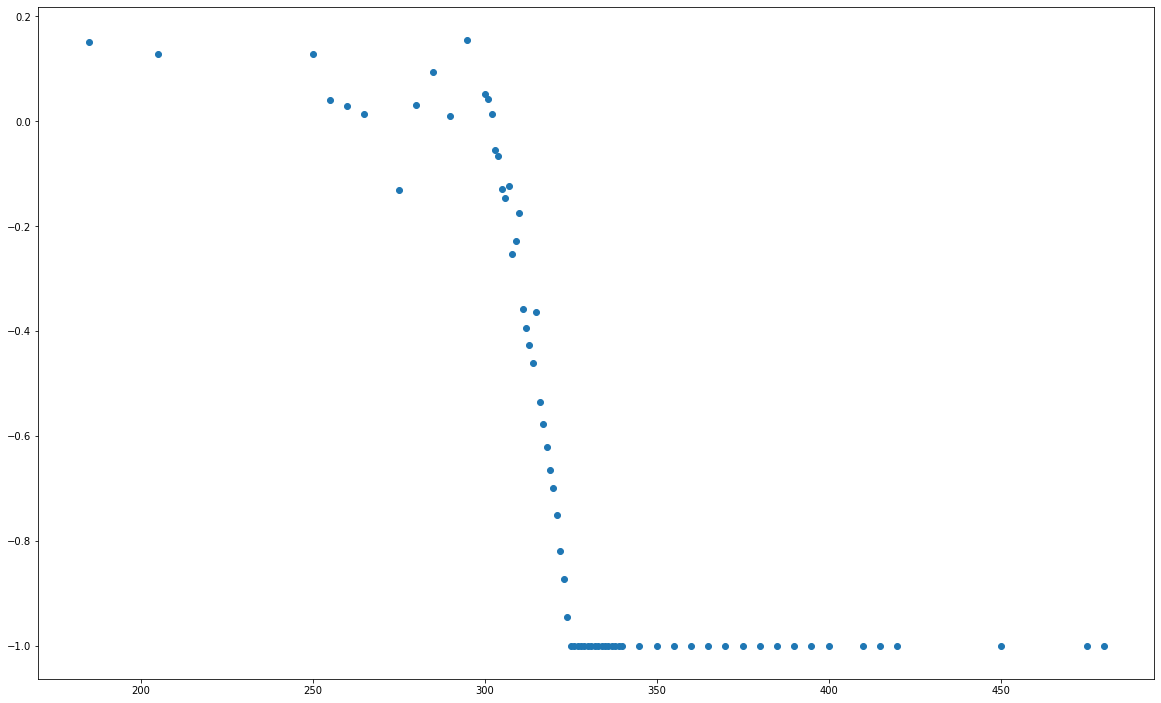

In [89]:
plt.figure(figsize=(20,20/1.618))
plt.scatter(dataOut.strike, dataOut.expvalue/dataOut.premium)
plt.show()

In [15]:
#Double check that expected loss includes all steps below the strike